In [1]:
!git clone https://github.com/MorningStarTM/Does-vision-pre-training-contribute-to-XAI.git

Cloning into 'Does-vision-pre-training-contribute-to-XAI'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 46 (delta 24), reused 38 (delta 20), pack-reused 0
Unpacking objects: 100% (46/46), 8.00 KiB | 744.00 KiB/s, done.


In [2]:
%cd Does-vision-pre-training-contribute-to-XAI

/kaggle/working/Does-vision-pre-training-contribute-to-XAI


In [3]:
!ls

LICENSE  README.md  models


# Import Libraries

In [4]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import time
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from IPython import display
import matplotlib.gridspec as gridspec
from models import VggAutoencoder

2024-07-26 14:27:01.694189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 14:27:01.694334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 14:27:01.813455: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
BATCH_SIZE = 32
EPOCHS = 10
H,W,C = 512,512,3
lr = 1e-5
latent_dim = 512

# Data Generator

In [6]:
datagen = ImageDataGenerator(rescale=1./255)

train_batches = datagen.flow_from_directory(
    '/kaggle/input/multi-cancer/Multi Cancer/Brain Cancer',
    target_size=(H,W),
    batch_size=BATCH_SIZE,
    class_mode='input',  # Use 'input' mode for autoencoder training
    shuffle=True
)

Found 15000 images belonging to 3 classes.


In [7]:
test_batches = datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset',
    target_size=(H,W),
    batch_size=BATCH_SIZE,
    class_mode='input',  # Use 'input' mode for autoencoder training
    shuffle=True
)

Found 7023 images belonging to 2 classes.


# AutoEncoder

In [8]:
vae = VggAutoencoder((H,W,C))
model = vae.build_autoencoder()
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 8, 8, 512)      │    31,449,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 512, 512, 3)    │    40,886,931 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,336,675 (275.94 MB)

 Trainable params: 72,336,675 (275.94 MB)

 Non-trainable params: 0 (0.00 B)

# Loss

In [9]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

model.compile(optimizer=Adam(1e-5), loss=ssim_loss)

In [10]:
checkpoint_filepath = '/kaggle/working/vggpt_brain.keras'
cbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
]

# Training

In [15]:
history = model.fit(train_batches, steps_per_epoch=15000  // BATCH_SIZE, epochs=25, callbacks=cbacks, validation_data=test_batches)

Epoch 1/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1571
Epoch 1: val_loss improved from 0.22756 to 0.22375, saving model to /kaggle/working/vggpt_brain.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - loss: 0.1571 - val_loss: 0.2238
Epoch 2/25
  1/468 ━━━━━━━━━━━━━━━━━━━━ 8:36 1s/step - loss: 0.1482
Epoch 2: val_loss did not improve from 0.22375
468/468 ━━━━━━━━━━━━━━━━━━━━ 83s 176ms/step - loss: 0.1482 - val_loss: 0.2241
Epoch 3/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1561
Epoch 3: val_loss did not improve from 0.22375
468/468 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - loss: 0.1561 - val_loss: 0.2240
Epoch 4/25
  1/468 ━━━━━━━━━━━━━━━━━━━━ 8:34 1s/step - loss: 0.1394
Epoch 4: val_loss improved from 0.22375 to 0.22329, saving model to /kaggle/working/vggpt_brain.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 88s 187ms/step - loss: 0.1394 - val_loss: 0.2233
Epoch 5/25
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1535
Epoch 5: val_loss improved from 0.22329 to 0.22147, saving m

KeyboardInterrupt: 

In [17]:
model.load_weights(checkpoint_filepath)
print("model loaded")
batch_images, _ = next(test_batches)
predictions = model.predict(batch_images)

model loaded
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


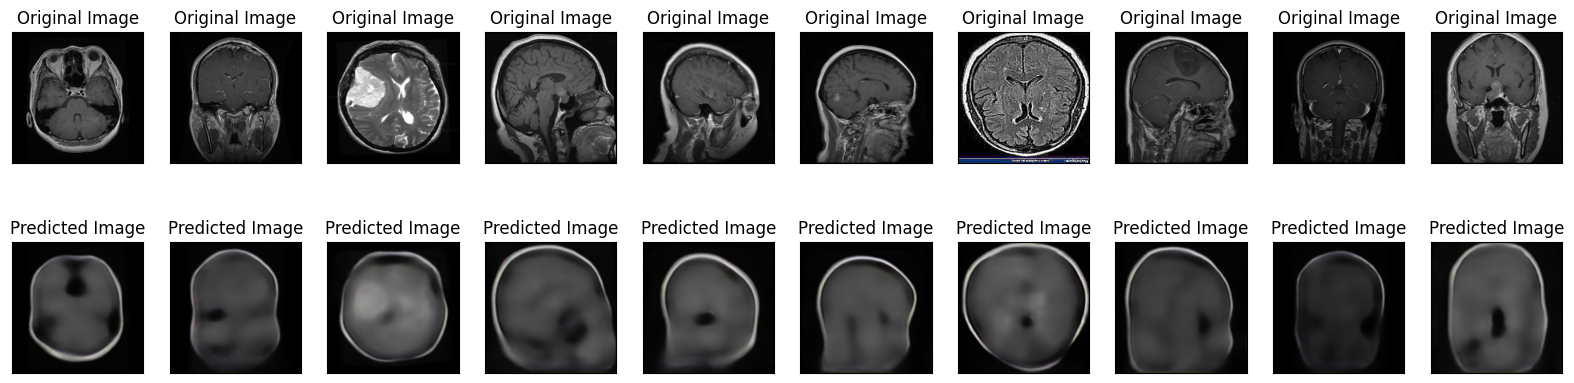

In [18]:
n = 10
plt.figure(figsize=(20,5))
for i in range(n):
    
    ax = plt.subplot(2, n, i+1)
    ax.set_title("Original Image")
    plt.imshow(batch_images[i].reshape(512, 512 ,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    ax.set_title("Predicted Image")
    plt.imshow(predictions[i].reshape(512, 512 ,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)